<a href="https://colab.research.google.com/github/nujl/Test-Scores-Prediction/blob/main/Kaggle_student_test_scores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext rpy2.ipython

Python Packages

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

R Packages

In [ ]:
%%R
if(require('pacman')) {
  install.packages('pacman')
}
pacman::p_load(ggplot2, dplyr, car, gridExtra)

---
# Data

In [4]:
%%R
df <- read.csv("https://raw.githubusercontent.com/nujl/Test-Scores-Prediction/main/test_scores.csv")
summary(df)

    school          school_setting     school_type         classroom        
 Length:2133        Length:2133        Length:2133        Length:2133       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
 teaching_method      n_student     student_id           gender         
 Length:2133        Min.   :14.0   Length:2133        Length:2133       
 Class :character   1st Qu.:20.0   Class :character   Class :character  
 Mode  :character   Median :22.0   Mode  :character   Mode  :character  
                    Mean   :22.8                                        
                    3rd Qu.:27.0                                        
                    Max

In [5]:
df = %R df
df.head()

,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest
1,ANKYI,Urban,Non-public,6OL,Standard,20.0,2FHT3,Female,Does not qualify,62.0,72.0
2,ANKYI,Urban,Non-public,6OL,Standard,20.0,3JIVH,Female,Does not qualify,66.0,79.0
3,ANKYI,Urban,Non-public,6OL,Standard,20.0,3XOWE,Male,Does not qualify,64.0,76.0
4,ANKYI,Urban,Non-public,6OL,Standard,20.0,556O0,Female,Does not qualify,61.0,77.0
5,ANKYI,Urban,Non-public,6OL,Standard,20.0,74LOE,Male,Does not qualify,64.0,76.0


In [6]:
na_dict = {col:sum(df[col].isna()) for col in df.columns}
pd.Series(na_dict)

school             0
school_setting     0
school_type        0
classroom          0
teaching_method    0
n_student          0
student_id         0
gender             0
lunch              0
pretest            0
posttest           0
dtype: int64

No null values

---
# EDA
- Categorical variables except classroom and student id

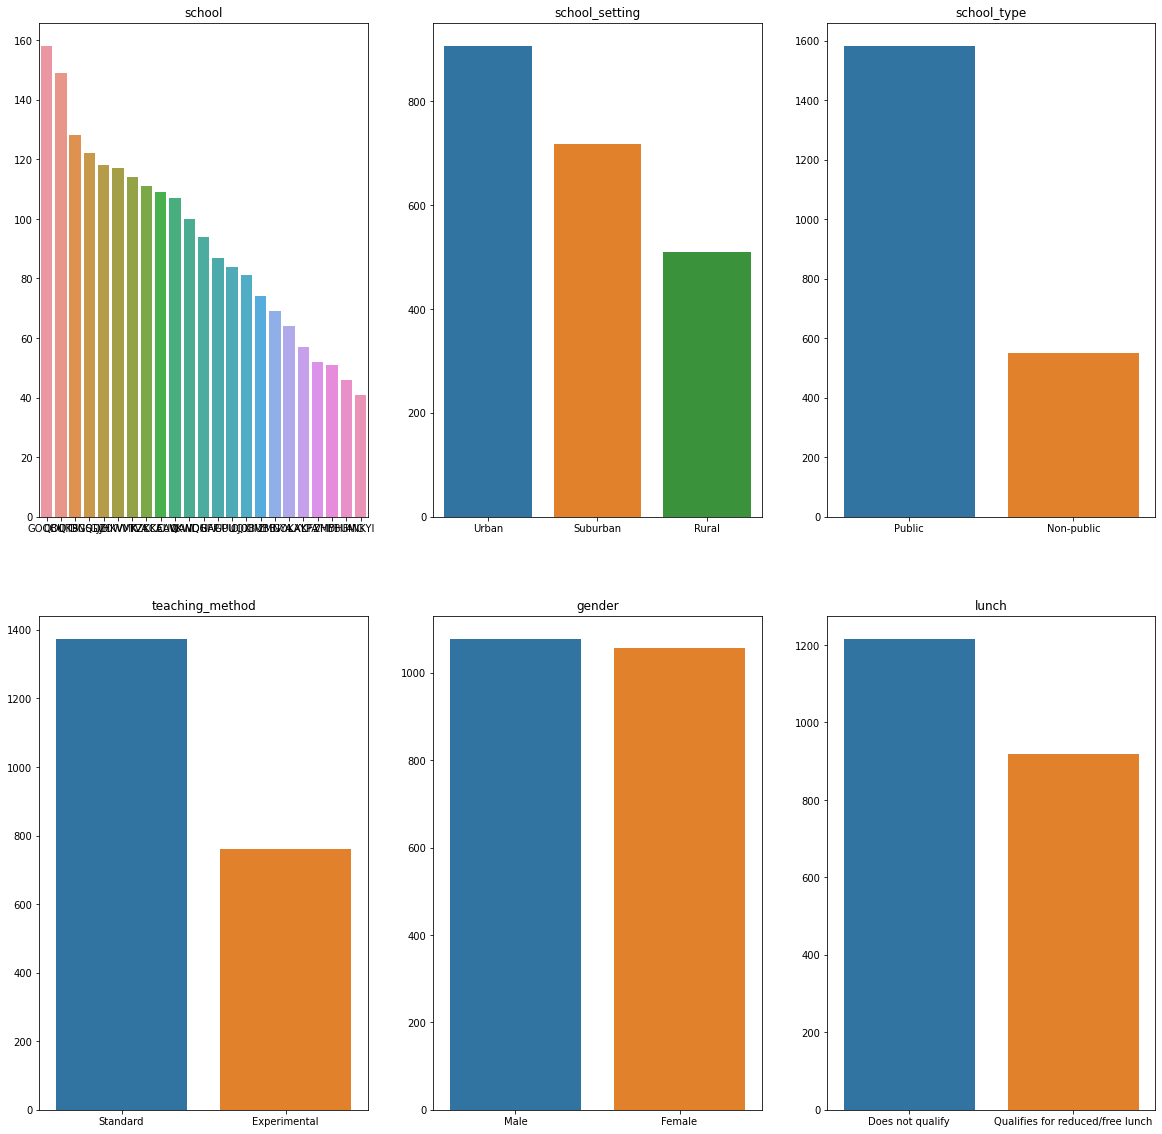

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

cat_cols = ["school", "school_setting", "school_type", "teaching_method", "gender", "lunch"]
cords = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2)]
fig, axs = plt.subplots(2,3, figsize=(20, 20))

for i,col in enumerate(cat_cols):
    vals = df[col].value_counts().to_dict()
    sns.barplot(x=list(vals.keys()), y=list(vals.values()), ax=axs[cords[i]])
    axs[cords[i]].set_title(col)

- Numerical Variables

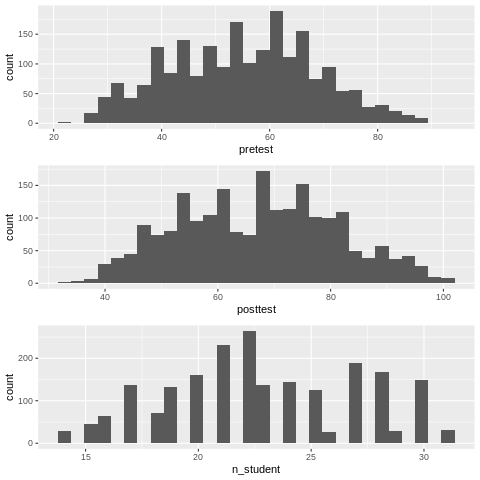

In [8]:
%%R
library(gridExtra)

p1 <- ggplot(df)+
  geom_histogram(aes(x=pretest))
p2 <- ggplot(df)+
  geom_histogram(aes(x=posttest))
p3 <- ggplot(df)+
  geom_histogram(aes(x=n_student))

grid.arrange(p1, p2, p3, nrow=3)

In [9]:
%%R
as.factor(df$n_student)
best_classes <- df %>%
  group_by(school, classroom) %>%
  summarise(
    score = mean(posttest)
  )
best_classes <- data.frame(best_classes)
head(best_classes[order(best_classes$score, decreasing=TRUE),])

`summarise()` has grouped output by 'school'. You can override using the
`.groups` argument.
   school classroom    score
42  IDGFP       P2A 98.41176
68  UKPGS       08N 93.85714
69  UKPGS       9AW 93.16000
40  IDGFP       98D 92.04762
70  UKPGS       IPU 91.52632
93  ZMNYA       V77 90.08696


In [10]:
%%R
df %>%
  group_by(school, classroom) %>%
  summarise(
      count = n()
  )

`summarise()` has grouped output by 'school'. You can override using the
`.groups` argument.
# A tibble: 97 × 3
# Groups:   school [23]
   school classroom count
   <chr>  <chr>     <int>
 1 ANKYI  6OL          20
 2 ANKYI  ZNS          21
 3 CCAAW  2B1          18
 4 CCAAW  EPS          20
 5 CCAAW  IQN          15
 6 CCAAW  PGK          21
 7 CCAAW  UHU          16
 8 CCAAW  UWK          19
 9 CIMBB  A33          19
10 CIMBB  EID          21
# … with 87 more rows


In [11]:
%%R 
df %>%
  group_by(lunch) %>%
  summarise(
      avg_posttest = mean(posttest),
      avg_pretest = mean(pretest)
  )

# A tibble: 2 × 3
  lunch                            avg_posttest avg_pretest
  <chr>                                   <dbl>       <dbl>
1 Does not qualify                         74.4        62.3
2 Qualifies for reduced/free lunch         57.5        45.2


- Students from UKPGS performed extremely well
- 23 schools, 97 classrooms in total
- Can't use student_id because they're all unique
- Distribution of posttest and pretest approximately normal, might have to scale for better performance, but I decided not to
- Might not need school since theres classroom data
- Somehow lunch might be a significant variable, probably because qualification for free lunch can indicate that ones not rich

---
# Multiple Regression using R

In [12]:
%%R
df.clean <- subset(df, select=-c(student_id))

#approx 3/4 of whole dataset
inds <- sample(nrow(df.clean), 1700)
train <- df.clean[inds,]
test <- df.clean[-inds,]

fit1 <- lm(posttest ~ ., data=train)
Anova(fit1)

      sums of squares computed by model comparison



Anova Table (Type II tests)

Response: posttest
                 Sum Sq   Df  F value    Pr(>F)    
school                     0                       
school_setting             0                       
school_type                0                       
classroom        4260.7   72   7.5893 < 2.2e-16 ***
teaching_method            0                       
n_student                  0                       
gender             31.3    1   4.0123   0.04534 *  
lunch             417.9    1  53.5917 3.891e-13 ***
pretest          2459.4    1 315.4158 < 2.2e-16 ***
Residuals       12475.5 1600                       
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [13]:
%%R
df.clean2 <- subset(df.clean, select=-c(school, school_setting, school_type, n_student, teaching_method)) # removed all variables that have no F statistic
fit2 <- lm(posttest ~ ., data=df.clean2)
Anova(fit2)

Anova Table (Type II tests)

Response: posttest
           Sum Sq   Df F value    Pr(>F)    
classroom 24117.9   96  32.291 < 2.2e-16 ***
gender       64.3    1   8.269  0.004075 ** 
lunch       572.5    1  73.579 < 2.2e-16 ***
pretest    3228.5    1 414.954 < 2.2e-16 ***
Residuals 15817.3 2033                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [14]:
%%R
df.clean3 <- subset(df.clean2, select=-c(gender)) # removed gender because pvalue > 0.001
fit.final <- lm(posttest ~ ., data=df.clean3)
Anova(fit.final)

Anova Table (Type II tests)

Response: posttest
           Sum Sq   Df F value    Pr(>F)    
classroom 24054.0   96  32.090 < 2.2e-16 ***
lunch       568.3    1  72.785 < 2.2e-16 ***
pretest    3317.8    1 424.915 < 2.2e-16 ***
Residuals 15881.6 2034                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [15]:
%%R
summary(fit.final) # Final model, each classroom and lunch status are intercepts and pretest is the slope


Call:
lm(formula = posttest ~ ., data = df.clean3)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.6090 -1.8041  0.0429  1.8096  9.6912 

Coefficients:
                                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)                            52.54662    1.60932  32.651  < 2e-16 ***
classroom08N                            5.92833    0.88078   6.731 2.19e-11 ***
classroom0N7                          -10.19068    0.98745 -10.320  < 2e-16 ***
classroom18K                          -14.43585    0.93482 -15.442  < 2e-16 ***
classroom197                           -0.65947    0.97832  -0.674 0.500334    
classroom1Q1                           -9.01785    0.86297 -10.450  < 2e-16 ***
classroom1SZ                           -9.12657    0.89153 -10.237  < 2e-16 ***
classroom1UU                            0.88288    0.83781   1.054 0.292102    
classroom1VD                          -11.17003    1.00150 -11.153  < 2e-16 ***
classroom21Q                          -

In [16]:
%%R
X_test <- subset(test, select=-c(school, school_setting, school_type, n_student, teaching_method, posttest))
Y_test <- subset(test, select=posttest)
preds <- predict(fit2, X_test)

In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def eval(ytest, pred):
    ytest = np.array(ytest)
    ytest.tolist()
    ytest = [y[0] for y in ytest]
    pred = np.array(pred)
    print(f"MSE: {mean_squared_error(ytest, pred)}")
    print(f"R2Score: {r2_score(ytest, pred)}")

    return ytest, pred

ytest = %R Y_test
pred = %R preds
ytest, pred = eval(ytest, pred)

MSE: 7.39911999235206
R2Score: 0.9622687340315063


In [18]:
import plotly.express as px
px.scatter(x=ytest, y=pred, title="true vs predicted", labels={'x': 'true', 'y':'predicted'}, trendline="ols")

# Neural Nets

In [19]:
df_new = df.drop(columns=["student_id"])
df_new = pd.get_dummies(df_new)

from sklearn.model_selection import train_test_split

X = df_new.drop(columns=["posttest"], inplace=False)
y = df_new.posttest

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [20]:
from tensorflow import keras
from tensorflow.keras import layers

In [21]:
model = keras.Sequential()

model.add(keras.Input(shape=(X.shape[1])))

model.add(layers.Dense(256,kernel_initializer='normal',activation='relu'))

model.add(layers.Dense(128,activation='relu'))

model.add(layers.Dense(64,activation='relu'))

model.add(layers.Dense(32,activation='relu'))

model.add(layers.Dense(1,activation='linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               34304     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 77,569
Trainable params: 77,569
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(
    loss="mse",
    optimizer="adam",
    metrics=["mse"]
)

In [23]:
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), batch_size=128, epochs=150, verbose=1
)

Epoch 1/150
12/12 [==============================] - 1s 29ms/step - loss: 3105.0728 - mse: 3105.0728 - val_loss: 985.6273 - val_mse: 985.6273
Epoch 2/150
12/12 [==============================] - 0s 7ms/step - loss: 345.1188 - mse: 345.1188 - val_loss: 321.8859 - val_mse: 321.8859
Epoch 3/150
12/12 [==============================] - 0s 9ms/step - loss: 115.1790 - mse: 115.1790 - val_loss: 132.6858 - val_mse: 132.6858
Epoch 4/150
12/12 [==============================] - 0s 11ms/step - loss: 62.6051 - mse: 62.6051 - val_loss: 47.8395 - val_mse: 47.8395
Epoch 5/150
12/12 [==============================] - 0s 7ms/step - loss: 36.5748 - mse: 36.5748 - val_loss: 29.4511 - val_mse: 29.4511
Epoch 6/150
12/12 [==============================] - 0s 8ms/step - loss: 24.9516 - mse: 24.9516 - val_loss: 23.5312 - val_mse: 23.5312
Epoch 7/150
12/12 [==============================] - 0s 7ms/step - loss: 21.6365 - mse: 21.6365 - val_loss: 21.0822 - val_mse: 21.0822
Epoch 8/150
12/12 [====================

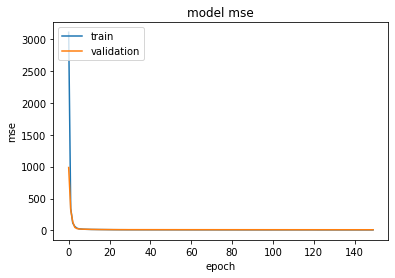

In [24]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [25]:
pred = model.predict(X_test).tolist()
pred = [p[0] for p in pred]
mean_squared_error(np.array(y_test), pred)

10.547006227464635

In [26]:
r2_score(np.array(y_test), pred)

0.9472285533744699

In [27]:
px.scatter(x=y_test, y=pred, title="true vs predicted", labels={'x': 'true', 'y':'predicted'}, trendline="ols")

- Neural network performed well, as epoch increased, MSE dropped.
- However multiple regression outperformed neural network

# Regression without pretest variable

In [28]:
%%R
df.clean <- subset(df, select=-c(student_id, pretest))

#approx 3/4 of whole dataset
inds <- sample(nrow(df.clean), 1700)
train <- df.clean[inds,]
test <- df.clean[-inds,]

fit1 <- lm(posttest ~ ., data=train)
Anova(fit1)

      sums of squares computed by model comparison



Anova Table (Type II tests)

Response: posttest
                Sum Sq   Df F value    Pr(>F)    
school                    0                      
school_setting            0                      
school_type               0                      
classroom        40744   72  61.101 < 2.2e-16 ***
teaching_method           0                      
n_student                 0                      
gender             160    1  17.262 3.428e-05 ***
lunch             1309    1 141.328 < 2.2e-16 ***
Residuals        14828 1601                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [29]:
%%R
train.clean.2 <- subset(train, select=-c(school, school_setting, school_type, teaching_method, n_student))

fit2 <- lm(posttest ~ ., data=train.clean.2)
Anova(fit2)

Anova Table (Type II tests)

Response: posttest
          Sum Sq   Df F value    Pr(>F)    
classroom 196032   96 220.481 < 2.2e-16 ***
gender       160    1  17.262 3.428e-05 ***
lunch       1309    1 141.328 < 2.2e-16 ***
Residuals  14828 1601                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [30]:
%%R
X_test <- subset(test, select=-c(school, school_setting, school_type, n_student, teaching_method, posttest))
Y_test <- subset(test, select=posttest)
preds <- predict(fit2, X_test)

In [31]:
ytest = %R Y_test
pred = %R preds
ytest, pred = eval(ytest, pred)

MSE: 10.41914393458981
R2Score: 0.9433559099595796


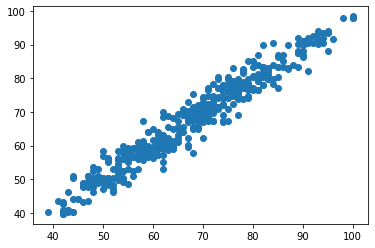

In [32]:
plt.scatter(ytest, pred)

Accuracy decreased slightly compared to the model with pretest variable. 

---
# TREE
- Same data that I used for neural nets

In [33]:
df_new = df.drop(columns=["student_id"])
df_new = pd.get_dummies(df_new)

from sklearn.model_selection import train_test_split

X = df_new.drop(columns=["posttest"], inplace=False)
y = df_new.posttest

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Decision Tree

In [34]:
from sklearn import tree

clf = tree.DecisionTreeRegressor()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"R2Score: {r2_score(y_test, pred)}")

MSE: 16.510031960227273
R2Score: 0.9173928362622794


In [35]:
importance = clf.feature_importances_
sorted_indices = np.argsort(importance)[::-1]
X_train.columns[sorted_indices]
def top_features(model):
    importance = model.feature_importances_
    sorted_indices = np.argsort(importance)[::-1][:10]
    cols = X_train.columns[sorted_indices]
    importance_dict={X_train.columns[i]:importance[i] for i in sorted_indices}
    plt.figure(figsize=(15,15))
    plt.barh(cols, importance[sorted_indices])
    plt.gca().invert_yaxis()

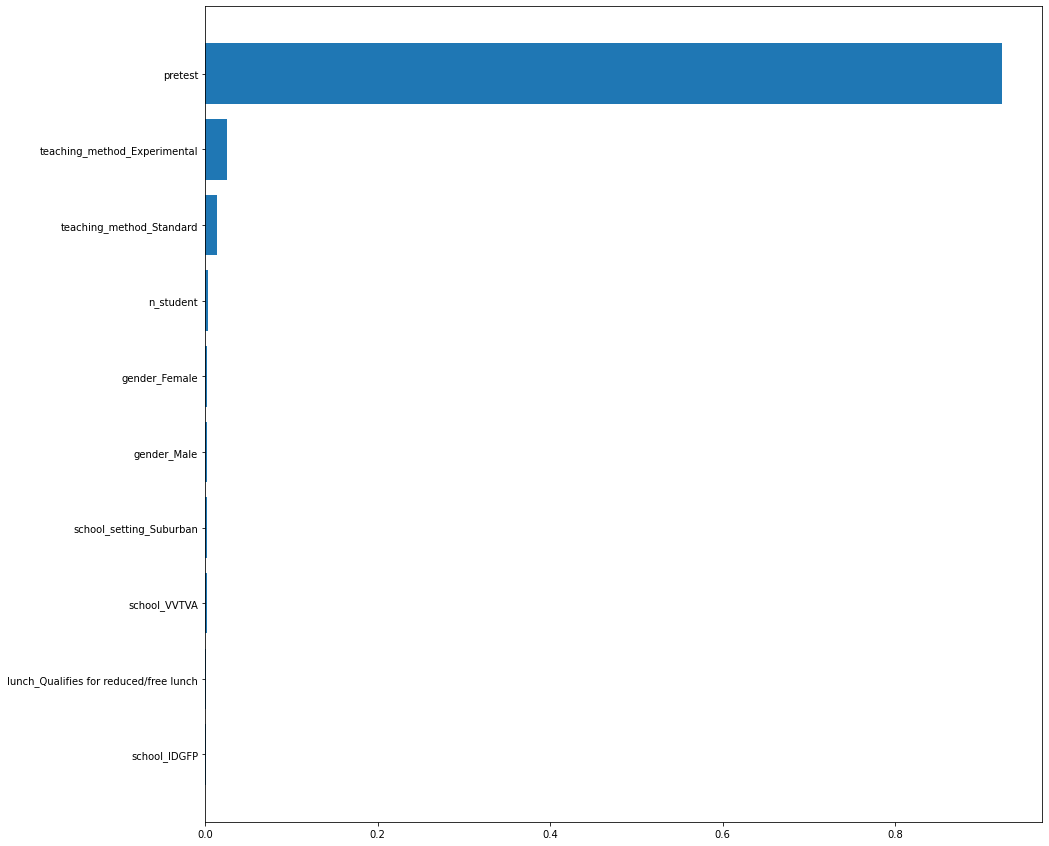

In [36]:
top_features(clf)

In [37]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data)
graph

### Random Forest

In [38]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"R2Score: {r2_score(y_test, pred)}")

MSE: 11.13824054671448
R2Score: 0.9442703404324666


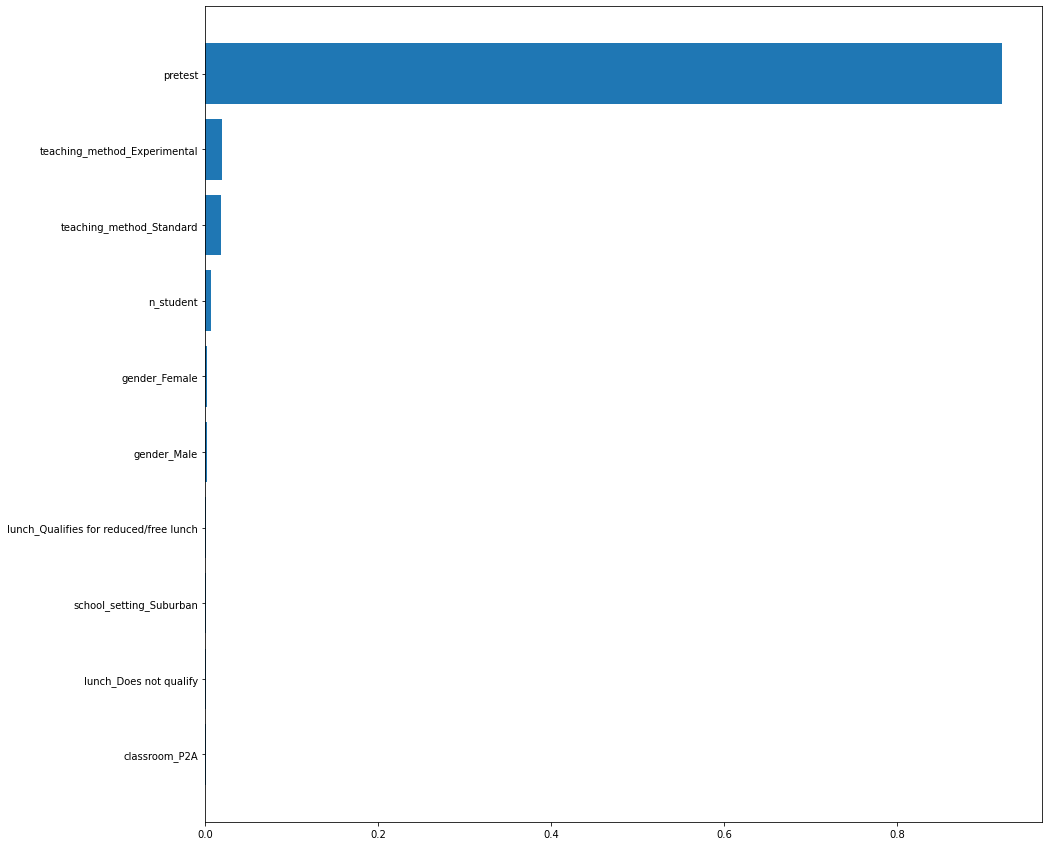

In [39]:
top_features(rf)

### LGBM

In [40]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor()
evals=[(X_test, y_test)]
lgbm.fit(X_train, y_train, eval_set=evals, eval_metric="mse")
pred = lgbm.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"R2Score: {r2_score(y_test, pred)}")

[1]	valid_0's l2: 164.567	valid_0's l2: 164.567
[2]	valid_0's l2: 135.768	valid_0's l2: 135.768
[3]	valid_0's l2: 112.292	valid_0's l2: 112.292
[4]	valid_0's l2: 93.3963	valid_0's l2: 93.3963
[5]	valid_0's l2: 77.7389	valid_0's l2: 77.7389
[6]	valid_0's l2: 65.2135	valid_0's l2: 65.2135
[7]	valid_0's l2: 54.9428	valid_0's l2: 54.9428
[8]	valid_0's l2: 46.7366	valid_0's l2: 46.7366
[9]	valid_0's l2: 39.9751	valid_0's l2: 39.9751
[10]	valid_0's l2: 34.513	valid_0's l2: 34.513
[11]	valid_0's l2: 30.0109	valid_0's l2: 30.0109
[12]	valid_0's l2: 26.334	valid_0's l2: 26.334
[13]	valid_0's l2: 23.3854	valid_0's l2: 23.3854
[14]	valid_0's l2: 20.9653	valid_0's l2: 20.9653
[15]	valid_0's l2: 19.0243	valid_0's l2: 19.0243
[16]	valid_0's l2: 17.3803	valid_0's l2: 17.3803
[17]	valid_0's l2: 16.0843	valid_0's l2: 16.0843
[18]	valid_0's l2: 15.0054	valid_0's l2: 15.0054
[19]	valid_0's l2: 14.0884	valid_0's l2: 14.0884
[20]	valid_0's l2: 13.3617	valid_0's l2: 13.3617
[21]	valid_0's l2: 12.761	valid_0

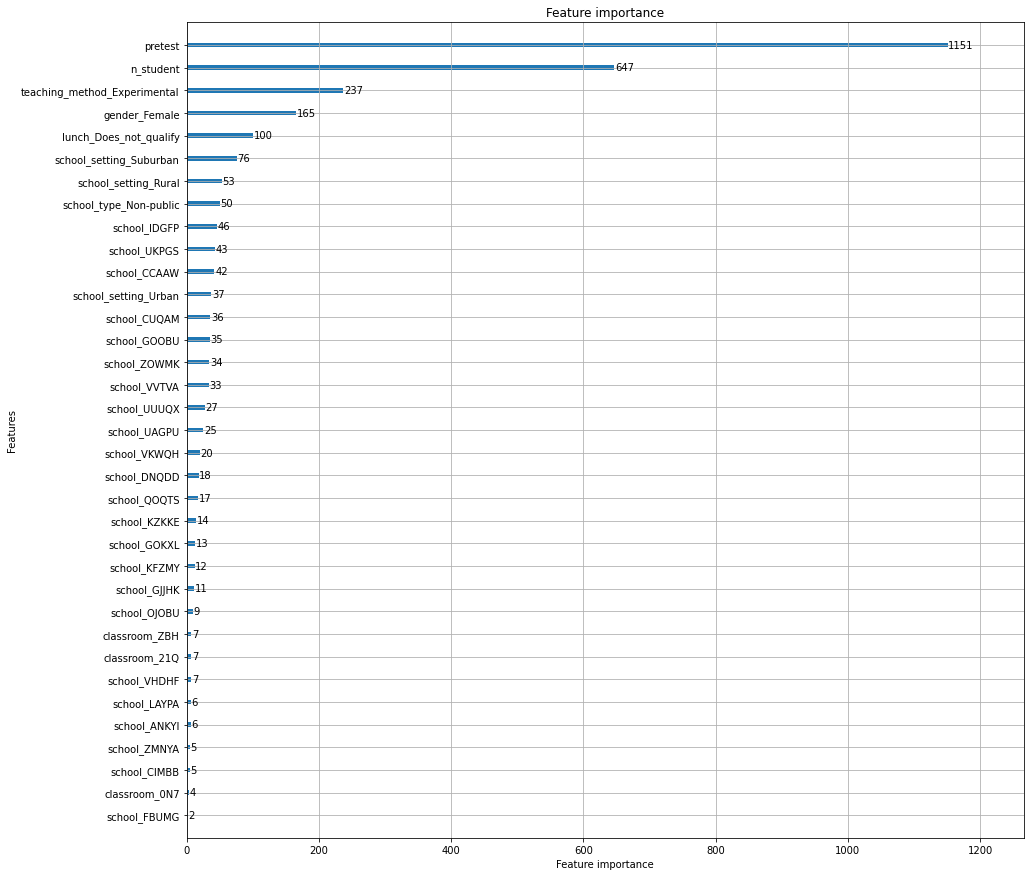

In [41]:
from lightgbm import plot_importance
%matplotlib inline

fig, ax = plt.subplots(figsize=(15,15))
plot_importance(lgbm, ax=ax)

????? n_students and teaching method turned out to be very impactful.....?
I can probably adjust the parameters of the models and use cross validation to improve the performance. Although the difference is marginal, performance is LGBM > RandomForest > DecisionTrees.

---
# Tree Models without pretest variable

In [42]:
df_new = df.drop(columns=["student_id", "pretest"])
df_new = pd.get_dummies(df_new)

from sklearn.model_selection import train_test_split

X = df_new.drop(columns=["posttest"], inplace=False)
y = df_new.posttest

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [43]:
clf = tree.DecisionTreeRegressor()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"R2Score: {r2_score(y_test, pred)}")

MSE: 12.548298167829563
R2Score: 0.9372151838423597


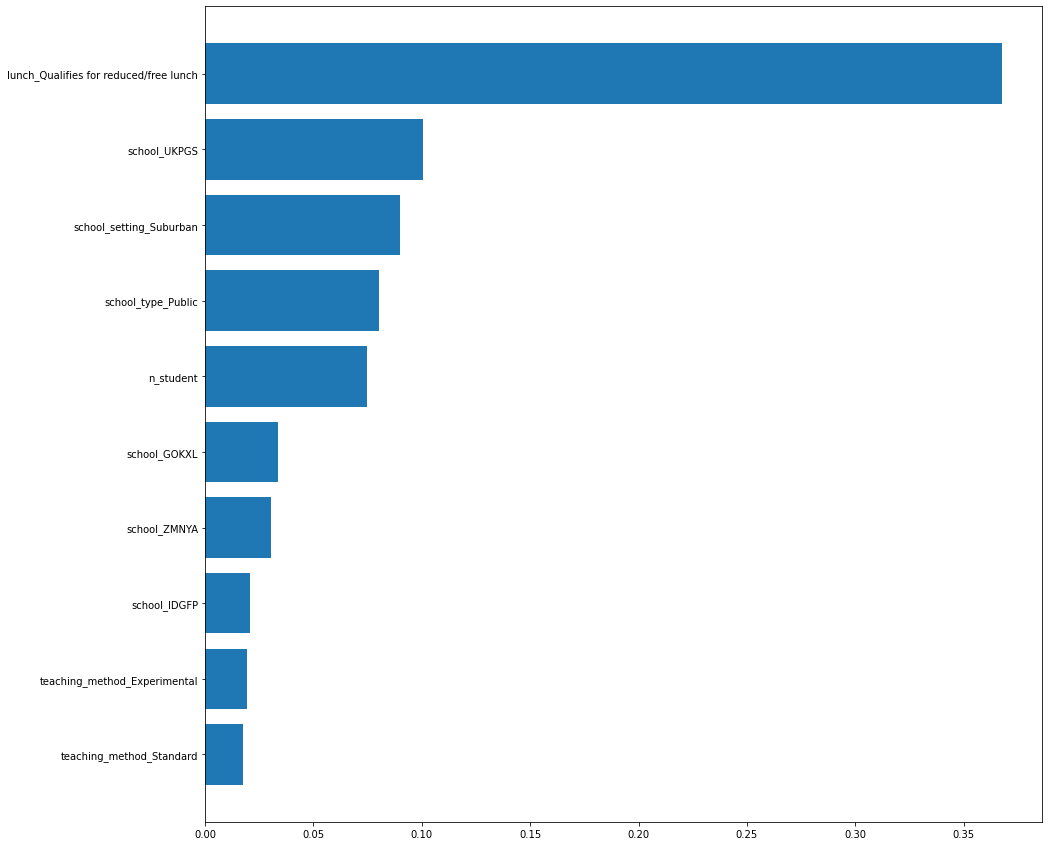

In [44]:
top_features(clf)

MSE: 12.548298167829563
R2Score: 0.9372151838423597


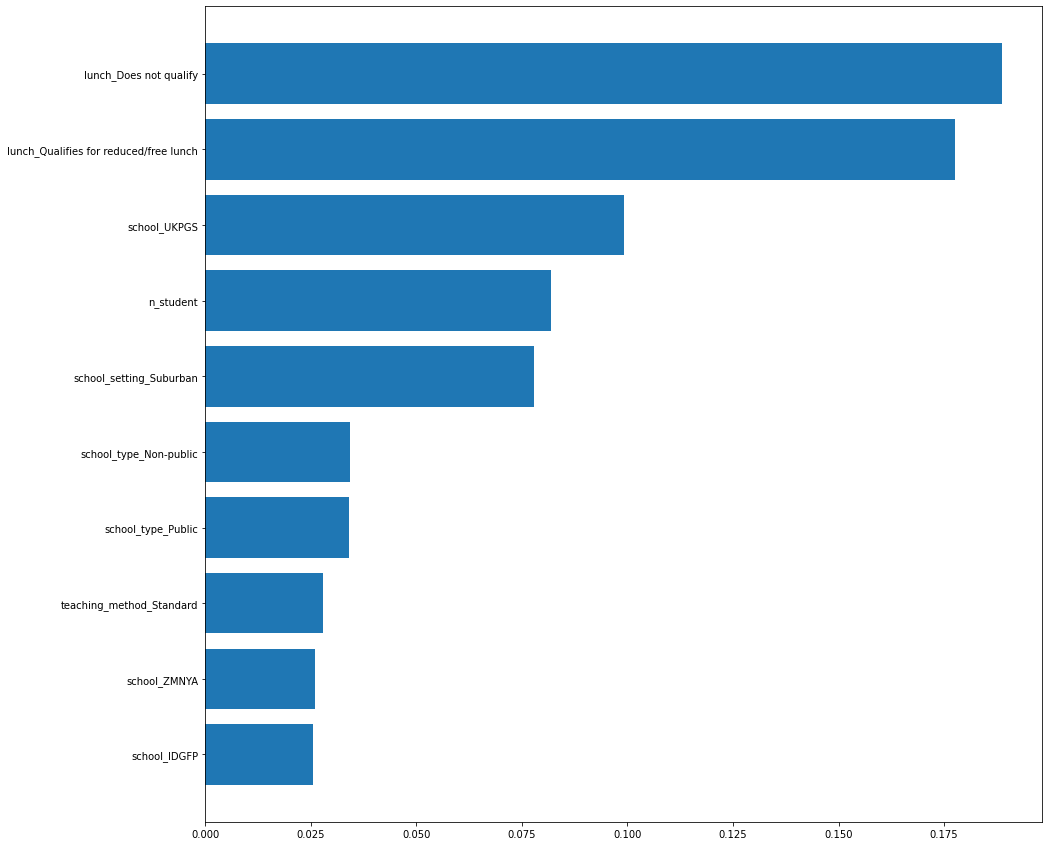

In [45]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rfpred = rf.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"R2Score: {r2_score(y_test, pred)}")
top_features(rf)

In [46]:
px.line(X_test, rfpred)

In [47]:
lgbm = LGBMRegressor()
evals=[(X_test, y_test)]
lgbm.fit(X_train, y_train, eval_set=evals, eval_metric="mse")
pred = lgbm.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"R2Score: {r2_score(y_test, pred)}")

[1]	valid_0's l2: 167.967	valid_0's l2: 167.967
[2]	valid_0's l2: 141.956	valid_0's l2: 141.956
[3]	valid_0's l2: 120.358	valid_0's l2: 120.358
[4]	valid_0's l2: 102.967	valid_0's l2: 102.967
[5]	valid_0's l2: 88.6734	valid_0's l2: 88.6734
[6]	valid_0's l2: 77.1177	valid_0's l2: 77.1177
[7]	valid_0's l2: 67.7473	valid_0's l2: 67.7473
[8]	valid_0's l2: 60.207	valid_0's l2: 60.207
[9]	valid_0's l2: 53.6887	valid_0's l2: 53.6887
[10]	valid_0's l2: 48.338	valid_0's l2: 48.338
[11]	valid_0's l2: 43.9265	valid_0's l2: 43.9265
[12]	valid_0's l2: 40.3943	valid_0's l2: 40.3943
[13]	valid_0's l2: 37.1456	valid_0's l2: 37.1456
[14]	valid_0's l2: 34.487	valid_0's l2: 34.487
[15]	valid_0's l2: 32.418	valid_0's l2: 32.418
[16]	valid_0's l2: 30.6764	valid_0's l2: 30.6764
[17]	valid_0's l2: 29.1837	valid_0's l2: 29.1837
[18]	valid_0's l2: 27.7663	valid_0's l2: 27.7663
[19]	valid_0's l2: 26.7717	valid_0's l2: 26.7717
[20]	valid_0's l2: 25.7398	valid_0's l2: 25.7398
[21]	valid_0's l2: 24.9545	valid_0's 

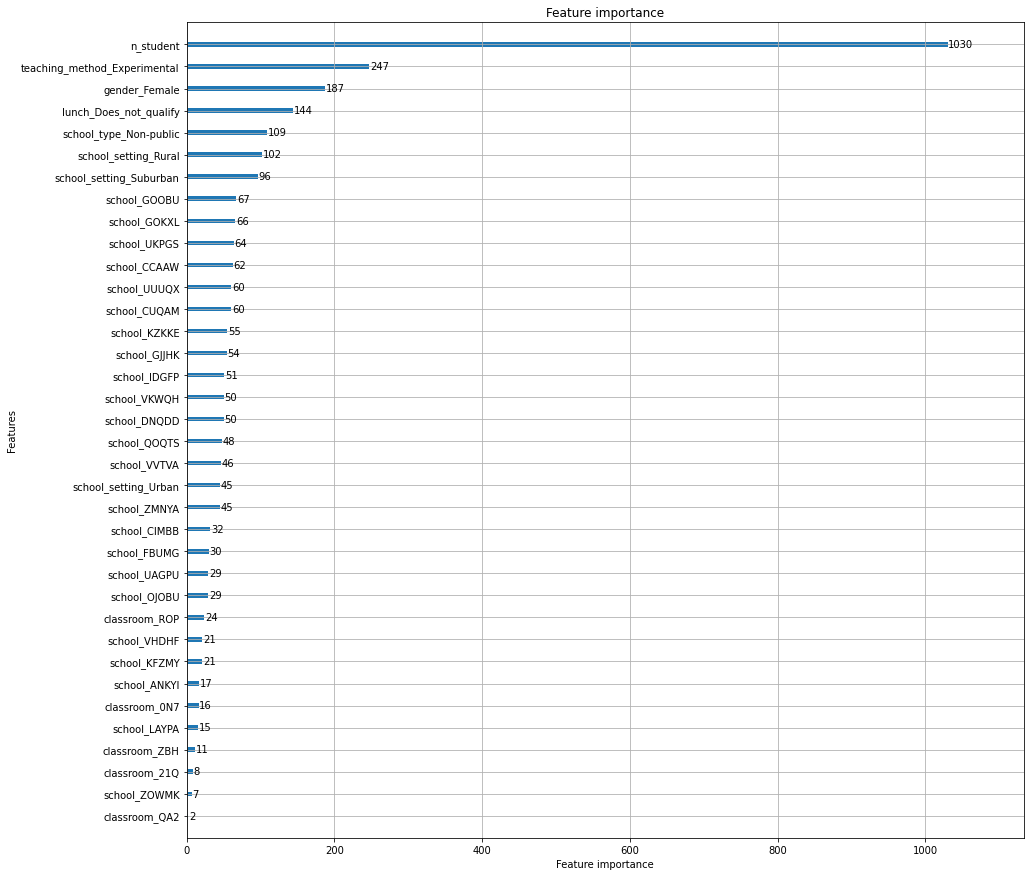

In [48]:
fig,ax = plt.subplots(figsize=(15,15))
plot_importance(lgbm, ax=ax)

# Cross validation w/ xgboost

In [49]:
from sklearn.model_selection import cross_validate
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
dtr = tree.DecisionTreeRegressor(max_depth=7)
rf = RandomForestRegressor()
xgb = XGBRegressor(n_estimators=1000, verbosity=0)

models = [lr, dtr, rf, xgb]

scoring = {'r2': 'r2',
          'mse':'neg_mean_squared_error'}

for model in models:
    scores = cross_validate(model, X, y, scoring=scoring, cv=5, return_train_score=True)
    print(model.__class__.__name__)
    print(f"Average train r2: {np.mean(scores['train_r2'])}")
    print(f"Average test r2: {np.mean(scores['test_r2'])}")
    print(f"Average train mse: {np.mean(scores['train_mse']) * -1}")
    print(f"Average test mse: {np.mean(scores['test_mse']) * -1}\n")

LinearRegression
Average train r2: 0.9528623138915716
Average test r2: -8.548824930149896e+22
Average train mse: 9.011292722684868
Average test mse: 1.2680295393929338e+25

DecisionTreeRegressor
Average train r2: 0.8898031741412533
Average test r2: -0.08156390621697054
Average train mse: 21.17715195639982
Average test mse: 149.23849571316114

RandomForestRegressor
Average train r2: 0.9578337650311681
Average test r2: 0.04934009779710582
Average train mse: 8.06845075318922
Average test mse: 133.19330331794202

XGBRegressor
Average train r2: 0.957539507672035
Average test r2: 0.18359715426160586
Average train mse: 8.125014696801657
Average test mse: 109.57398430479354



I feel like the scores are very wrong...

# xgboost alone

In [50]:
xgb = XGBRegressor(n_estimators=1000, verbosity=0)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)

print(f"MSE: {mean_squared_error(y_test, preds)}")
print(f"R2Score: {r2_score(y_test, preds)}")

MSE: 11.515308654575703
R2Score: 0.9423836979958317


In [51]:
px.scatter(x=y_test, y=preds, trendline="ols")

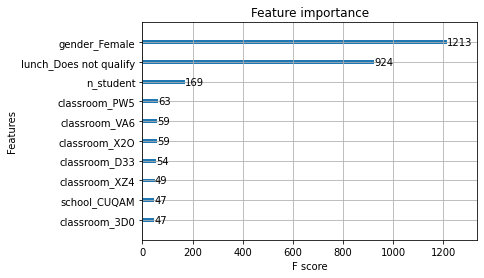

In [52]:
from xgboost import plot_importance
plot_importance(xgb, max_num_features=10)

Gender is an important variable here